In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances

In [ ]:
df = pd.read_csv('Каширец.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[['X1', 'X2']], df['Y'])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].scatter(df['X1'], df['X2'], c=df['Y'])
ax[0, 1].scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train)

ax[1, 0].scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test)

In [5]:
def get_coeff(point1, point2):
    delta_x = point1[0] - point2[0]
    delta_y = point1[1] - point2[1]
    coeff_a = delta_y / delta_x

    x_center = (point1[0] + point2[0]) / 2
    y_center = (point1[1] + point2[1]) / 2
    coeff_b = y_center - coeff_a * x_center
    
    return coeff_a, coeff_b


def get_reverse_coeff(point1, point2):
    delta_x = point1[0] - point2[0]
    delta_y = point1[1] - point2[1]
    coeff_a = -1 / (delta_y / delta_x)

    x_center = (point1[0] + point2[0]) / 2
    y_center = (point1[1] + point2[1]) / 2
    coeff_b = y_center - coeff_a * x_center
    
    return coeff_a, coeff_b

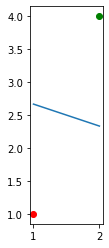

In [6]:
point_1 = [1, 1]
point_2 = [2, 4]

def my_f(x, point1=point_1, point2=point_2):
    a, b = get_reverse_coeff(point1, point2)
    return a * x + b

# plt.plot([point_1[0], point_2[0]], [point_1[1], point_2[1]])
plt.plot(*point_1, 'ro')
plt.plot(*point_2, 'go')
plt.plot([point_1[0], point_2[0]], [my_f(point_1[0]), my_f(point_2[0])])
plt.gca().set_aspect('equal')

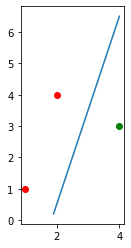

In [7]:
point_11 = [1, 1]
point_12 = [2, 4]
point_2 = [4, 3]


def get_reverse_coeff_for_3_points(point11, point12, point2):
    coeff_a, _ = get_reverse_coeff(point_11, point_12)
    return coeff_a, point_2[1] - coeff_a * point_2[0]


def my_f2(x, a=None, b=None):
    if not (a and b):
        a, b = get_reverse_coeff_for_3_points(point_11, point_12, point_2)
    return a * x + b


def get_coord_point_perp(point11, point12, point2):
    a1, b1 = get_coeff(point11, point12)
    a2, b2 = get_reverse_coeff_for_3_points(point11, point12, point2)
    x = (b2 - b1) / (a1 - a2)
    return x, my_f2(x, a=a2, b=b2)


# plt.plot([point_11[0], point_12[0]], [point_11[1], point_12[1]])
# plt.plot([point_2[0], np.min([point_11[0], point_12[0]])], [my_f2(point_2[0]), my_f2(np.min([point_11[0], point_12[0]]))])

plt.plot(point_11[0], point_11[1], 'ro')
plt.plot(point_12[0], point_12[1], 'ro')
plt.plot(point_2[0], point_2[1], 'go')

point_3 = get_coord_point_perp(point_11, point_12, point_2)
plt.plot([point_3[0], point_2[0]], [my_f(point_3[0], point_2, point_3), my_f(point_2[0], point_2, point_3)])

plt.gca().set_aspect('equal')

In [339]:
class MySVC:
    X = None
    y = None
    coeff_a = None
    coeff_b = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.y[self.y == 0] = -1
        
        points = self.__get_points()
        points[0][1], points[1][0] = points[1][0], points[0][1]

        mistakes = {}
        for p1 in points[0]:
            for p2 in points[1]:
                mistakes[(tuple(self.X.loc[p1].to_list()), tuple(self.X.loc[p2].to_list()))] = self.__check_points(self.X.loc[p1], self.X.loc[p2])

        for p2 in points[1]:
            p1 = self.__get_coord_point_perp(self.X.loc[points[0][0]], self.X.loc[points[0][1]], self.X.loc[p2])
            mistakes[tuple(p1), tuple(self.X.loc[p2].to_list())] = self.__check_points(p1, self.X.loc[p2])

        for p1 in points[0]:
            p2 = self.__get_coord_point_perp(self.X.loc[points[1][0]], self.X.loc[points[1][1]], self.X.loc[p1])
            mistakes[tuple(self.X.loc[p1].to_list()), tuple(p2)] = self.__check_points(self.X.loc[p1], p2)
        
        result_points = list(mistakes.keys())[np.argmin(list(mistakes.values()))]

        self.coeff_a, self.coeff_b = self.__get_reverse_coeff(*result_points)
        return mistakes

    def get_y_by_coeff(self, x):
        return self.coeff_a * x + self.coeff_b

    def __check_points(self, point1, point2):
        def get_dist_mistate(lim, x):
            coeff_a = .5 / (0 - lim)
            coeff_b = ((.5 + 0) / 2) - coeff_a * ((0 + lim) / 2)
            return coeff_a * x + coeff_b

        mistakes = 0
        a, b = self.__get_reverse_coeff(point1, point2)
        points = (0, a * 0 + b), (1, a * 1 + b)
        dist = lambda x, y: np.absolute((points[1][1] - points[0][1]) * x - (points[1][0] - points[0][0]) * y + points[1][0] * points[0][1] - points[1][1] * points[0][0])
        for i, p in enumerate(self.X.values):
            y = self.__func_for_2_points(p[0], point1, point2)
            if -((y[0] - p[1]) * self.y.iloc[i] * y[1]) < 0:
                mistakes += 1
            elif dist(*p) < dist(*point2):
                mistakes += get_dist_mistate(float(dist(*point1)), float(dist(*p))) if dist(*p) == 0.0 else .5
        return mistakes
    
    def __get_points(self):
        X_copy = self.X.copy()
        X_copy['res'] = self.y

        # Разделение датасета на 2 класса
        X_first_class = X_copy[X_copy['res'] == 1]
        X_first_class['index'] = np.arange(X_first_class.shape[0])
        X_second_class = X_copy[X_copy['res'] == -1]
        X_second_class['index'] = np.arange(X_second_class.shape[0])
        
        distances = pairwise_distances(X_first_class[['X1', 'X2']].values, X_second_class[['X1', 'X2']].values)
        
        first_points = np.argmin(distances) // X_second_class.shape[0], np.argmin(distances) % X_second_class.shape[0]
        # Удаление минимального, его строки и колонки
        distances[first_points[0], :] = np.max(distances)
        distances[:, first_points[1]] = np.max(distances)

        first_points = [X_first_class[X_first_class['index'] == first_points[0]].index[0],
                        X_second_class[X_second_class['index'] == first_points[1]].index[0]]
        second_points = np.argmin(distances) // X_second_class.shape[0], np.argmin(distances) % X_second_class.shape[0]
        second_points = [X_first_class[X_first_class['index'] == second_points[0]].index[0],
                         X_second_class[X_second_class['index'] == second_points[1]].index[0]]
        return [first_points, second_points]
    
    def __get_coeff(self, point1, point2):
        delta_x = point1[0] - point2[0]
        delta_y = point1[1] - point2[1]
        coeff_a = delta_y / delta_x

        x_center = (point1[0] + point2[0]) / 2
        y_center = (point1[1] + point2[1]) / 2
        coeff_b = y_center - coeff_a * x_center

        return coeff_a, coeff_b

    def __get_reverse_coeff(self, point1, point2):
        delta_x = point1[0] - point2[0]
        delta_y = point1[1] - point2[1]
        coeff_a = -1 / (delta_y / delta_x)

        x_center = (point1[0] + point2[0]) / 2
        y_center = (point1[1] + point2[1]) / 2

        return coeff_a, y_center - coeff_a * x_center
    
    def __func_for_2_points(self, x, point1, point2):
        a, b = self.__get_reverse_coeff(point1, point2)
        return a * x + b, a

    def __get_reverse_coeff_for_3_points(self, point11, point12, point2):
        coeff_a, _ = self.__get_reverse_coeff(point11, point12)
        return coeff_a, point2[1] - coeff_a * point2[0]

    def __func_for_3_points(self, x, point11, point12, point2):
        a, b = self.__get_reverse_coeff_for_3_points(point11, point12, point2)
        return a * x + b

    def __get_coord_point_perp(self, point11, point12, point2):
        a1, b1 = self.__get_coeff(point11, point12)
        a2, b2 = self.__get_reverse_coeff_for_3_points(point11, point12, point2)
        x = (b2 - b1) / (a1 - a2)
        return x, self.__func_for_3_points(x, point11, point12, point2)

    def predict(self, X):
        def get_y(x):
            return self.coeff_a * x + self.coeff_b

        results = np.zeros(X.shape[0])
        
        for i, item in enumerate(X.values):
            y = get_y(item[0])
            results[i] = -1 if (y - item[1]) * self.coeff_a > 0 else 1
        return results

In [424]:
import time
import warnings
warnings.filterwarnings('ignore')

svc = MySVC()

start = time.monotonic()
for i in range(100):
    mist = svc.fit(X_train, y_train)
    _ = svc.predict(X_test)
print(time.monotonic() - start)

4.6560000000026776


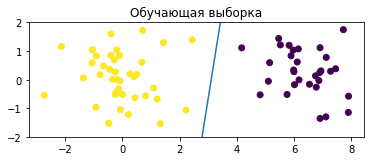

In [420]:
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train)
plt.plot([0, 6], [svc.get_y_by_coeff(0), svc.get_y_by_coeff(6)])
plt.ylim(bottom=-2, top=2)
plt.title('Обучающая выборка')
plt.gca().set_aspect('equal')

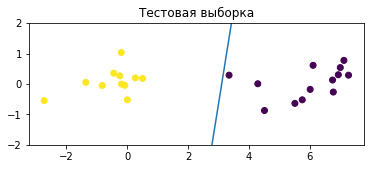

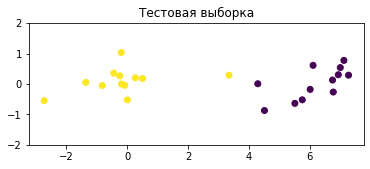

In [407]:
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=svc.predict(X_test))
plt.plot([0, 6], [svc.get_y_by_coeff(0), svc.get_y_by_coeff(6)])
plt.ylim(bottom=-2, top=2)
plt.title('Тестовая выборка')
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test)
plt.ylim(bottom=-2, top=2)
plt.title('Тестовая выборка')
plt.gca().set_aspect('equal')

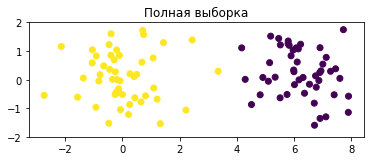

In [125]:
plt.scatter(df['X1'], df['X2'], c=df['Y'])
# plt.plot([0, 6], [svc.get_y_by_coeff(0), svc.get_y_by_coeff(6)])
plt.ylim(bottom=-2, top=2)
plt.title('Полная выборка')
plt.gca().set_aspect('equal')

0.125


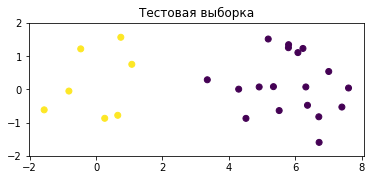

In [423]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

built_in_svc = SVC()

start = time.monotonic()
for _ in range(100):
    built_in_svc.fit(X_train, y_train)
    built_in_svc.predict(X_test)
print(time.monotonic() - start)

plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=built_in_svc.predict(X_test))
plt.ylim(bottom=-2, top=2)
plt.title('Тестовая выборка')
plt.gca().set_aspect('equal')

In [145]:
built_in_svc = SVC()
built_in_svc.fit(X_train, y_train)
built_in_svc.predict(X_test)

array([ 1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.])

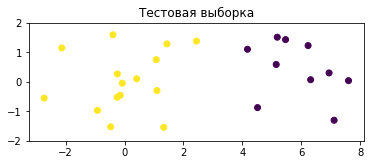

In [147]:
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=built_in_svc.predict(X_test))
plt.ylim(bottom=-2, top=2)
plt.title('Тестовая выборка')
plt.gca().set_aspect('equal')

array([ 1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.])

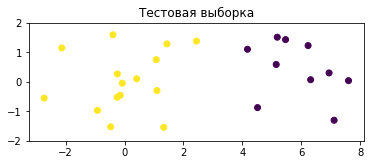

In [72]:
tuple(X_train.loc[23].to_list())

(3.349167015244169, 0.2893057649596959)

0.5


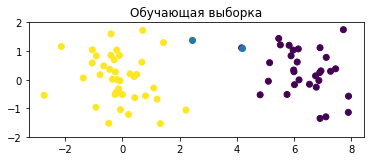

8.0


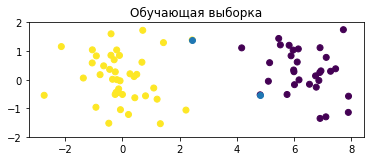

7.0


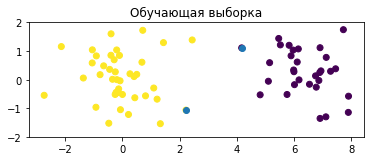

1.5


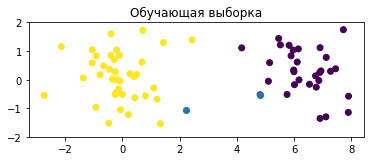

1.0


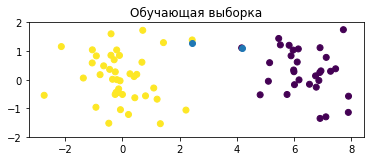

1.5


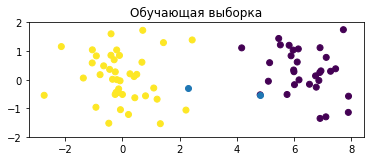

1.0


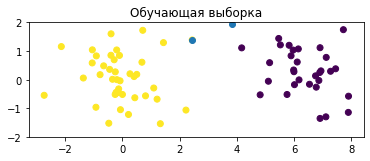

3.0


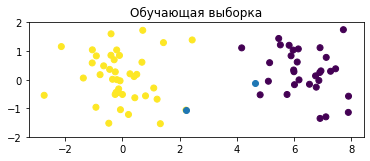

In [418]:
for p, m in mist.items():
    print(m)
    plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train)
    plt.scatter([p[0][0], p[1][0]], [p[0][1], p[1][1]])
    plt.ylim(bottom=-2, top=2)
    plt.title('Обучающая выборка')
    plt.gca().set_aspect('equal')
    plt.show()

In [323]:
get_coeff([2, 5], [3, 0])

(-5.0, 15.0)